In [1]:
%pylab inline
import pandas as pd
import statsmodels.api as sm
from scipy import stats
from itertools import product
import matplotlib.pyplot as plt
import warnings

def invboxcox(y,lmbda):
   if lmbda == 0:
      return(np.exp(y))
   else:
      return(np.exp(np.log(lmbda*y+1)/lmbda))

Populating the interactive namespace from numpy and matplotlib


# Прогнозирование уровня средней заработной платы в России
Для выполнения этого задания вам понадобятся данные о среднемесячных уровнях заработной платы в России:
```
WAG_C_M.csv
```
В файле записаны данные о заработной плате за каждый месяц с января 1993 по август 2016.

Необходимо проанализировать данные, подобрать для них оптимальную прогнозирующую модель в классе ARIMA и построить прогноз на каждый месяц на два года вперёд от конца данных.

__Review criteria__

Придерживайтесь стандартного алгоритма построения прогноза:

## Визуальный анализ ряда

In [2]:
df = pd.read_csv('WAG_C_M.csv', 
                 sep = ';', 
                 index_col=['month'],
                 parse_dates=['month'],
                 dayfirst=True)
df.head()

,WAG_C_M
month,
1993-01-01,15.3
1993-02-01,19.1
1993-03-01,23.6
1993-04-01,30.6
1993-05-01,37.5


<Figure size 1080x360 with 0 Axes>

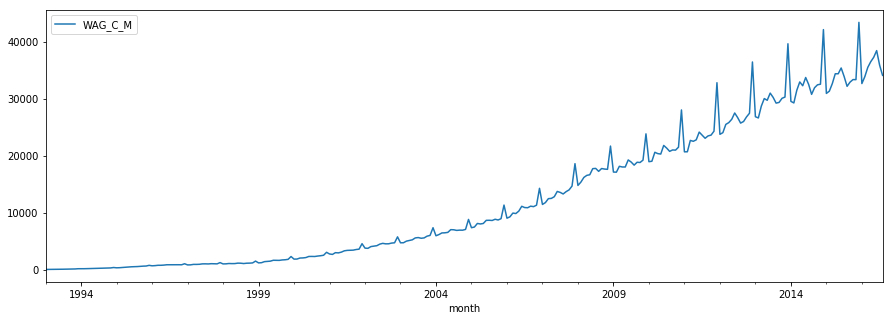

In [3]:
plt.figure(figsize(15,5))
df.plot()

Критерий Дики-Фуллера: p=0.991850


<Figure size 1080x720 with 0 Axes>

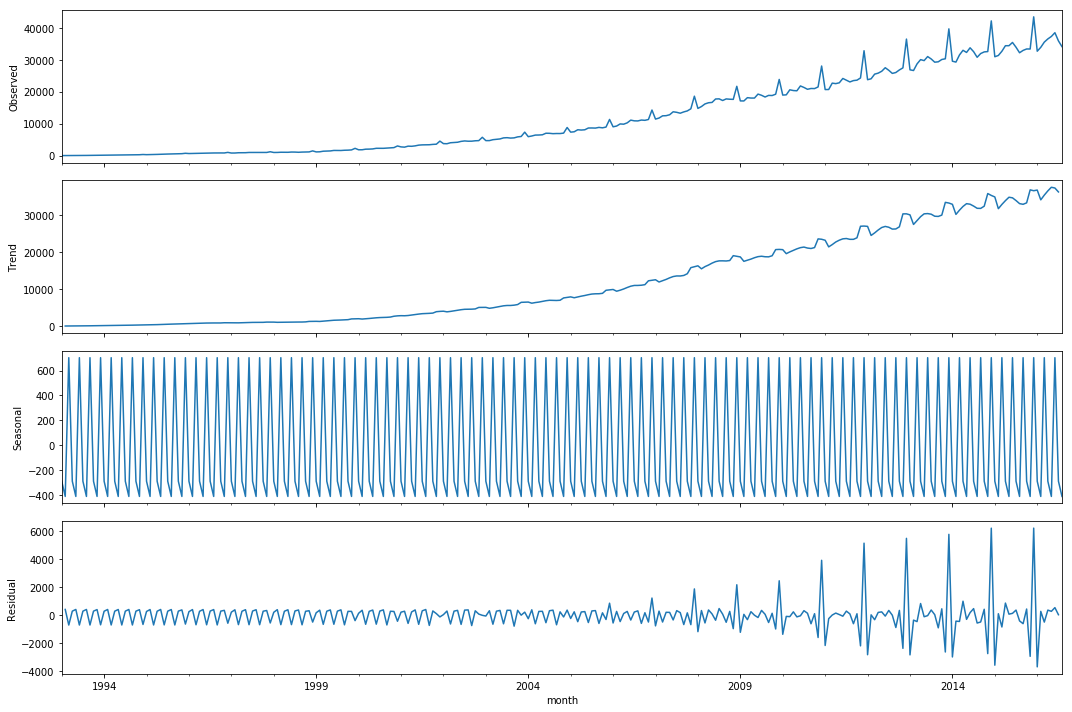

In [4]:
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(df.WAG_C_M, freq=3).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(df.WAG_C_M)[1])

На графике хорошо видны тренд и сезонность. Дисперсия с каждым сезоном растёт - ряд нестационарен. Тоже самое говорит критерий Дики-Фуллера.

## Стабилизация дисперсии (при необходимости)

Оптимальный параметр преобразования Бокса-Кокса: 0.263202
Критерий Дики-Фуллера: p=0.991850


<Figure size 1080x720 with 0 Axes>

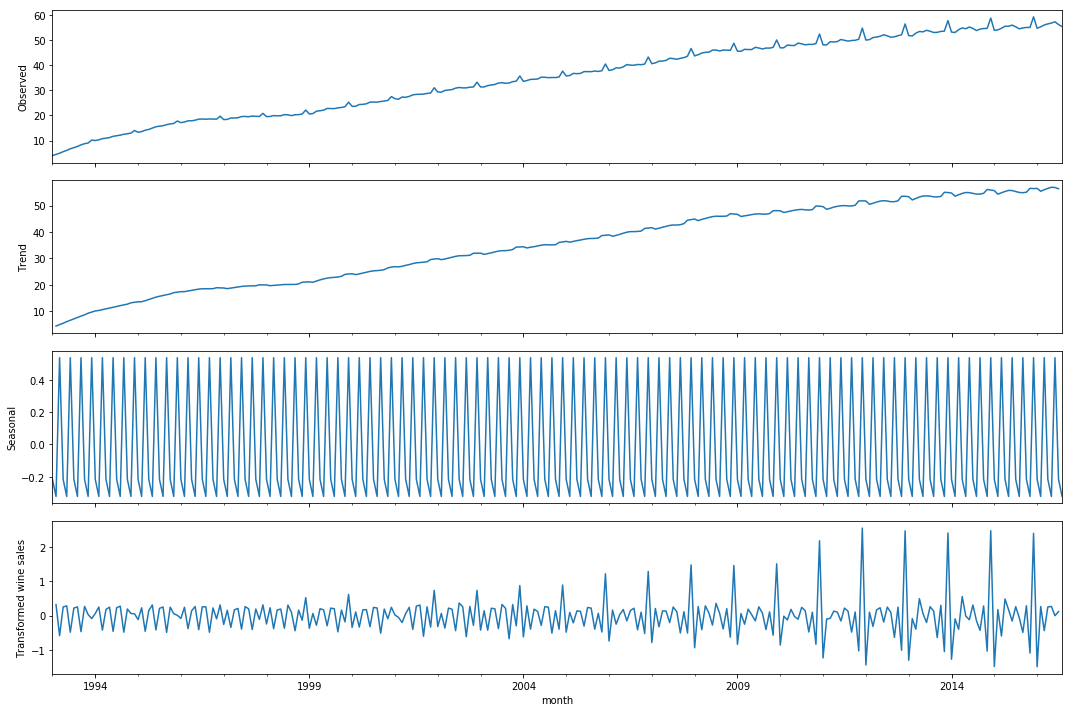

In [5]:
plt.figure(figsize(15,10))
df['WAG_C_M_box'], lmbda = stats.boxcox(df.WAG_C_M)
sm.tsa.seasonal_decompose(df.WAG_C_M_box, freq=3).plot()
plt.ylabel(u'Transformed wine sales')
print("Оптимальный параметр преобразования Бокса-Кокса: %f" % lmbda)
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(df.WAG_C_M)[1])

Дисперсия явно уменьшилась. Тренд стал более сглаженным. Остатки со временем имеют всё бОльший разброс. Критерий Дики-Фуллера показывает меньшее значение p_value, но всё равно гипотеза о нестационарности ряда не отвергается.

## Выбор порядка дифференцирования

Критерий Дики-Фуллера: p=0.014697


<Figure size 1080x720 with 0 Axes>

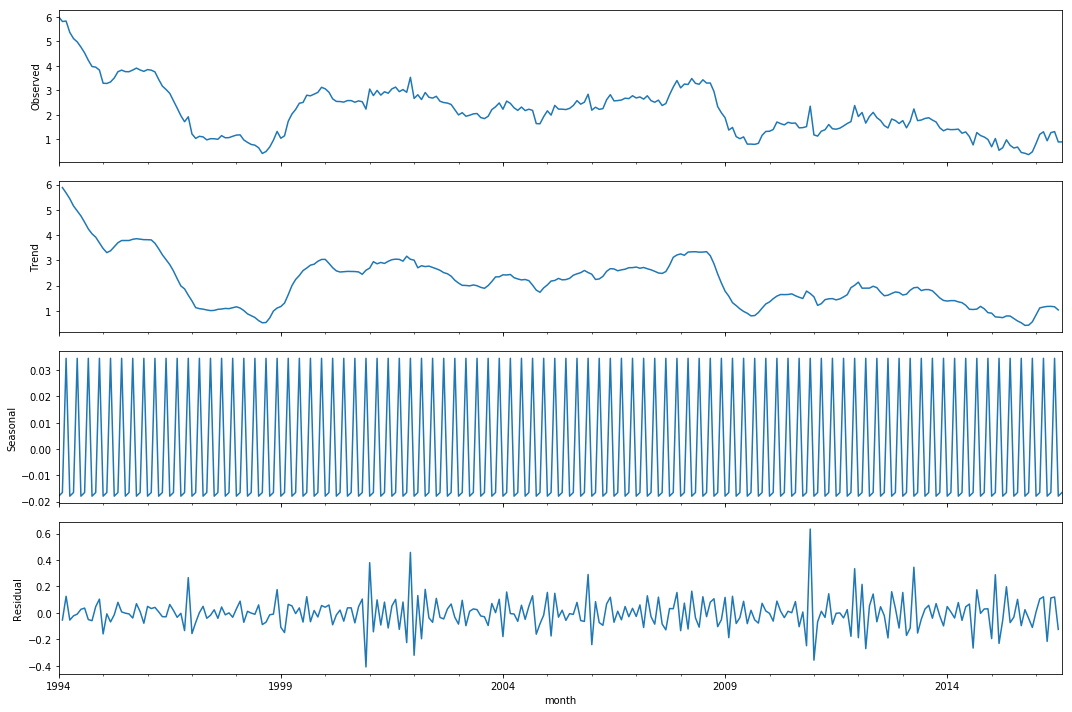

In [6]:
plt.figure(figsize(15,10))
df['WAG_C_M_box_diff'] = df.WAG_C_M_box - df.WAG_C_M_box.shift(12)
sm.tsa.seasonal_decompose(df.WAG_C_M_box_diff[12:], freq=3).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(df.WAG_C_M_box_diff[12:])[1])

Ошибка стала похожа на случайную с одинаковой дисперсией. Критерий Дики-Фуллера отвергает гипотезу о нестационарности ряда, но на графиках-то мы всё видим. Тренд теперь не так ярко выражен, но, увы, он есть. 

Критерий Дики-Фуллера: p=0.000000


<Figure size 1080x720 with 0 Axes>

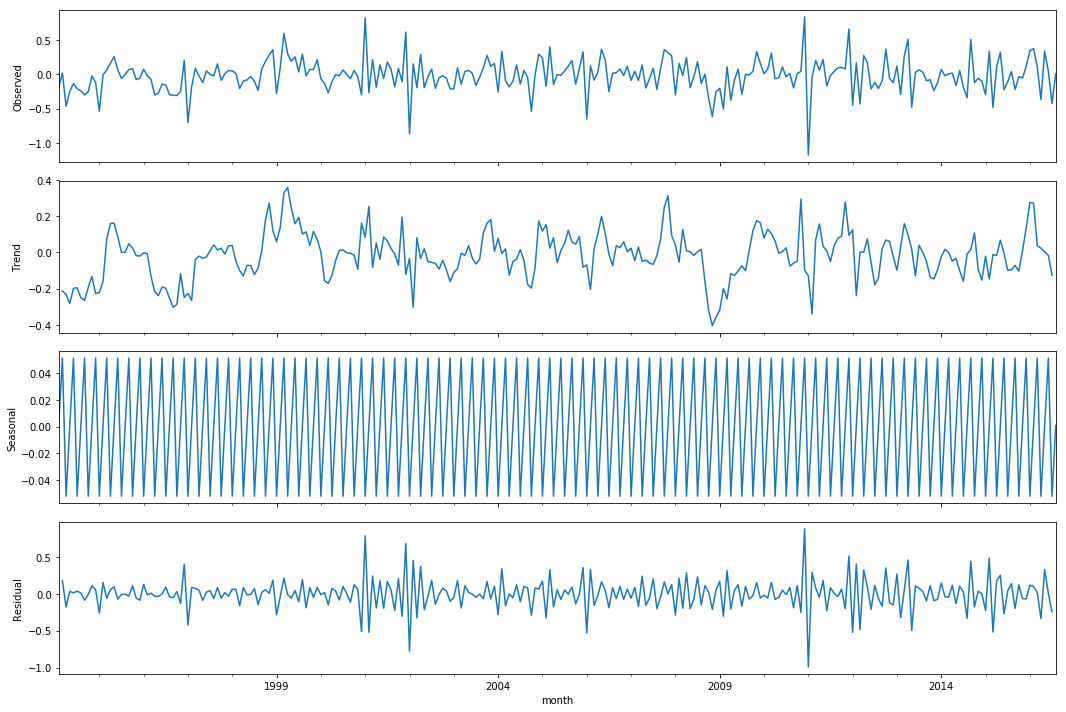

In [7]:
df['WAG_C_M_box_diff2'] = df.WAG_C_M_box_diff - df.WAG_C_M_box_diff.shift(1)
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(df.WAG_C_M_box_diff2[13:], freq=3).plot()   
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(df.WAG_C_M_box_diff2[13:])[1])

Тренд стал более случайным. Критерий Дики-Фуллера даёт p_value = 0.
## Выбор начальных приближений для $p,q,P,Q$

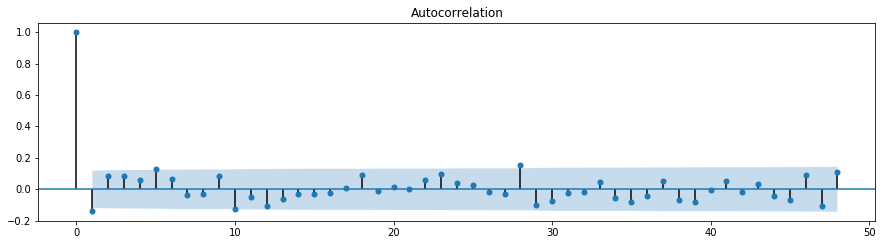

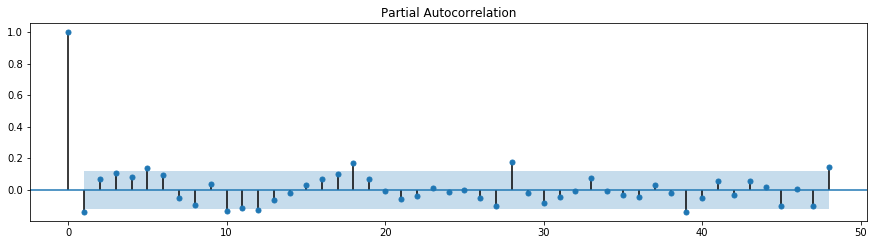

In [8]:
plt.figure(figsize(15,8))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(df.WAG_C_M_box_diff2[13:].values.squeeze(), lags=48, ax=ax)
pylab.show()
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(df.WAG_C_M_box_diff2[13:].values.squeeze(), lags=48, ax=ax)
pylab.show()

$$Q = 0, q = 1, P = 4, p = 1$$

## Обучение и сравнение моделей-кандидатов, выбор победителя

In [9]:
Qs = range(0, 1)
qs = range(0, 2)
Ps = range(0, 5)
ps = range(0, 2)
d=1
D=1

In [10]:
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

20

In [11]:
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parameters_list:
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(df.WAG_C_M_box, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

In [12]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

      parameters       aic
11  (1, 0, 1, 0)  0.340521
6   (0, 1, 1, 0)  1.170768
12  (1, 0, 2, 0)  1.622924
16  (1, 1, 1, 0)  2.021911
7   (0, 1, 2, 0)  2.509650


In [13]:
print(best_model.summary())

                                 Statespace Model Results                                 
Dep. Variable:                        WAG_C_M_box   No. Observations:                  284
Model:             SARIMAX(1, 1, 0)x(1, 1, 0, 12)   Log Likelihood                   2.830
Date:                            Thu, 16 Apr 2020   AIC                              0.341
Time:                                    22:01:05   BIC                             11.147
Sample:                                01-01-1993   HQIC                             4.679
                                     - 08-01-2016                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1488      0.046     -3.210      0.001      -0.240      -0.058
ar.S.L12      -0.1314      0.046   

## Анализ остатков построенной модели, при необходимости — её модификация: если остатки получаются смещёнными, прогноз нужно скорректировать на константу; если остатки нестационарны или автокоррелированы, можно попробовать расширить область, в которой подбираются значения $p,q,P,Q$.

Критерий Стьюдента: p=0.090792
Критерий Дики-Фуллера: p=0.000003


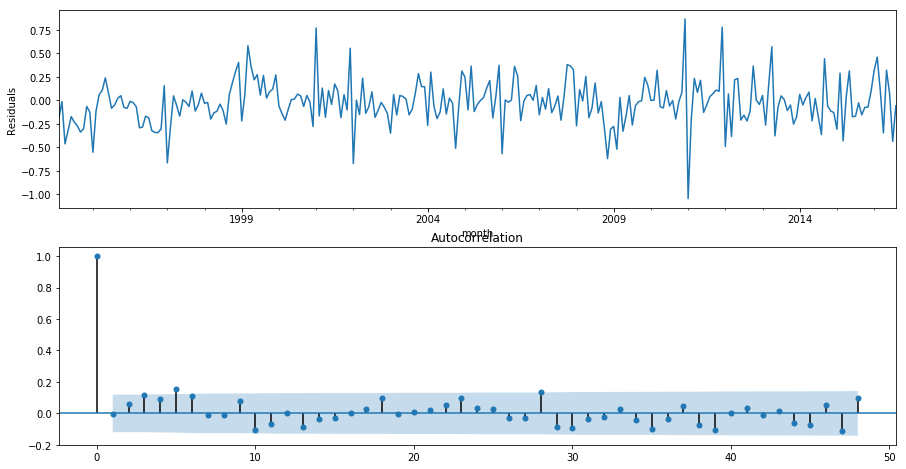

In [14]:
plt.figure(figsize(15,8))
plt.subplot(211)
best_model.resid[13:].plot()
plt.ylabel(u'Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=48, ax=ax)

print("Критерий Стьюдента: p=%f" % stats.ttest_1samp(best_model.resid[13:], 0)[1])
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[13:])[1])

Остатки не смещены (проверено с помощью критерия Стьюдента), стационарны (проверено с помощью критерия Дики-Фуллера) и не автокоррелированы (проверено с помощью коррелограммы).
7. Прогнозирование с помощью финальной модели.

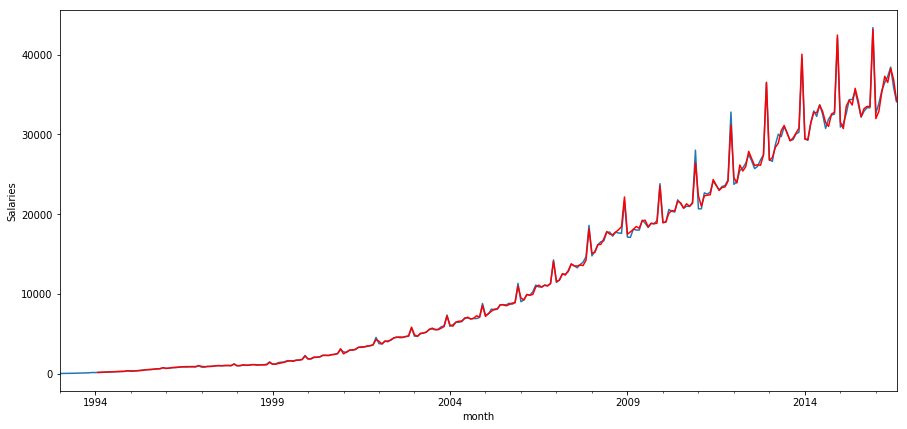

In [15]:
df['model'] = invboxcox(best_model.fittedvalues, lmbda)
df['model'] = df['model']
plt.figure(figsize(15,7))
df.WAG_C_M.plot()
df.model[13:].plot(color='r')
plt.ylabel('Salaries')
pylab.show()

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:320: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  freq=base_index.freq)


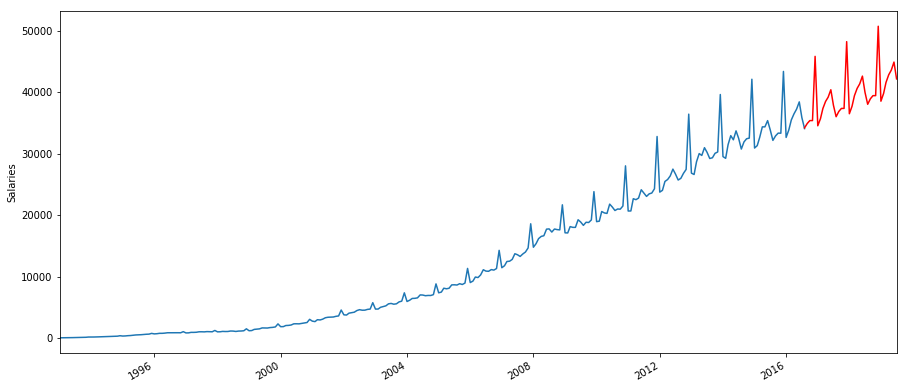

In [16]:
df2 = df[['WAG_C_M']]
date_list = [datetime.datetime.strptime("2016-08-01", "%Y-%m-%d") + relativedelta(months=x) for x in range(0,36)]
future = pd.DataFrame(index=date_list, columns= df2.columns)
df2 = pd.concat([df2, future])
df2['forecast'] = invboxcox(best_model.predict(start=283, end=320), lmbda)

plt.figure(figsize(15,7))
df2.WAG_C_M.plot()
df2.forecast.plot(color='r')
plt.ylabel('Salaries')
pylab.show()